<a href="https://colab.research.google.com/github/TuckerArrants/nlp/blob/master/NLP-with-Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Extraction with Disastor Tweets
*Author: Tucker Arrants*


**In this notebook, we will explore natural language processing (NLP) by analyzing 10,000 hand classified tweets. These tweets have been labelled as those about disasters, and those not. As an example, consider two hypothetical tweets:**

> That concert last night was FIRE!  
> There's a huge forest fire in Malibu right now!!!

**Both of these tweets invoke the notion of 'fire' but only the second is about a real natural disaster. Can we train a model to distinguish between the two? Let's see**

In [1]:
%matplotlib inline
#manipulation
import numpy as np
import pandas as pd
import os

#this is just cool
from tqdm import tqdm

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')   #for optimum aesthetics 
import seaborn as sns

#natural language processing
import string
import re
import nltk
from nltk.corpus import stopwords

#stemming/lemmatizing/vectorizing
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

#ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

#import stuff to set random seeds for reproducible results
import tensorflow as tf
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Before we start, it is good practice to seed everything at the beginning of a project to ensure reproducible results. We can do this now:**

In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything(34)

# I. Exploration

In [3]:
train = pd.read_csv('train (1).csv')
test = pd.read_csv('test.csv')

**We see that we have three features in this dataset: keyword, location, and text**

**We will save the ID column now for our final submission and combine data sets into a single DataFrame. We can drop location because it is missing too many values to be useful. But keyword contains information that we can add to our text data after filling missing values:**

In [4]:
#save ID
test_id = test['id']

#drop from train and test
columns = {'id', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#fill missing with unknown
train['keyword'] = train['keyword'].fillna('unknown')
test['keyword'] = test['keyword'].fillna('unknown')

#add keyword to tweets
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']

#drop fkeyword rom train and test
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#combine so we work smarter, not harder
total = train.append(test)

In [5]:
print('There are', len(train), 'rows in the train set')
print('There are', len(test), 'rows in the test set')

There are 7613 rows in the train set
There are 3263 rows in the test set


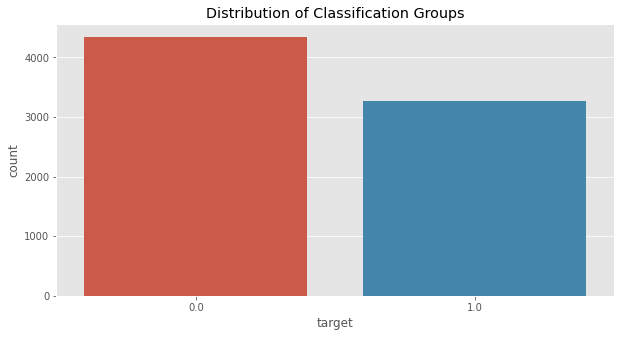

In [6]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
graph1 = sns.countplot(x = 'target', data = total)

#give title and plot
plt.title('Distribution of Classification Groups')
plt.show(graph1)

**So we have more tweets in class 0 (not a disaster tweet) than class 1 (disaster tweet)**

## Adding basic features

**We can easily add some new features to help us explore the attributes of tweets that are about disasters. If we think these new features are useful, we can add them as input for our neural network along with the text data**

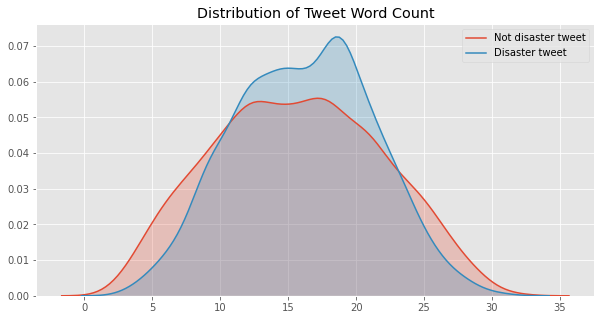

In [7]:
#create column for the number of words in tweet
total['word count'] = total['text'].apply(lambda x: len(x.split()))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['word count'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['word count'][train['target'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Word Count')
plt.show()

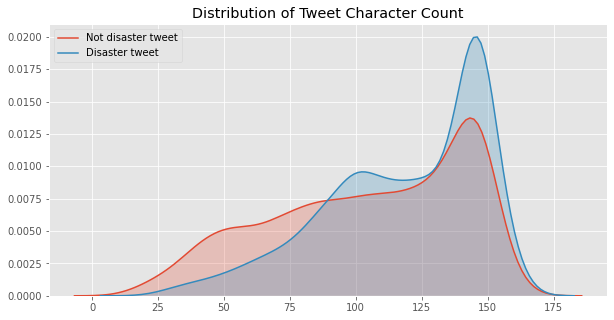

In [8]:
#create column for the number of characters in a tweet
total['character count'] = total['text'].apply(lambda x: len(x))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['character count'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['character count'][train['target'] == 1], shade = True, label = 'Disaster tweet')

#set title and plot
plt.title('Distribution of Tweet Character Count')
plt.show()

**This is insightful as it tells us that very few disaster tweets are less than 50 characters and that the majority of them are more than 125 characters long. What else can we explore?**

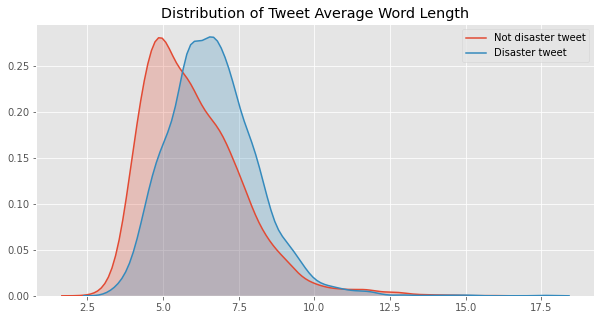

In [9]:
#define function to find average word length 
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#broadcast to text column
total['average word length'] = total['text'].apply(average_word_length)

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['average word length'][train['target'] == 0], shade = True, label = 'Not disaster tweet')
sns.kdeplot(train['average word length'][train['target'] == 1], shade = True, label = 'Disaster tweet')

#set title
plt.title('Distribution of Tweet Average Word Length')

#splot graphs
plt.show()

**Now that we have an idea of what new features to construct and how they might be useful, let's add the rest of them and visualize them:**

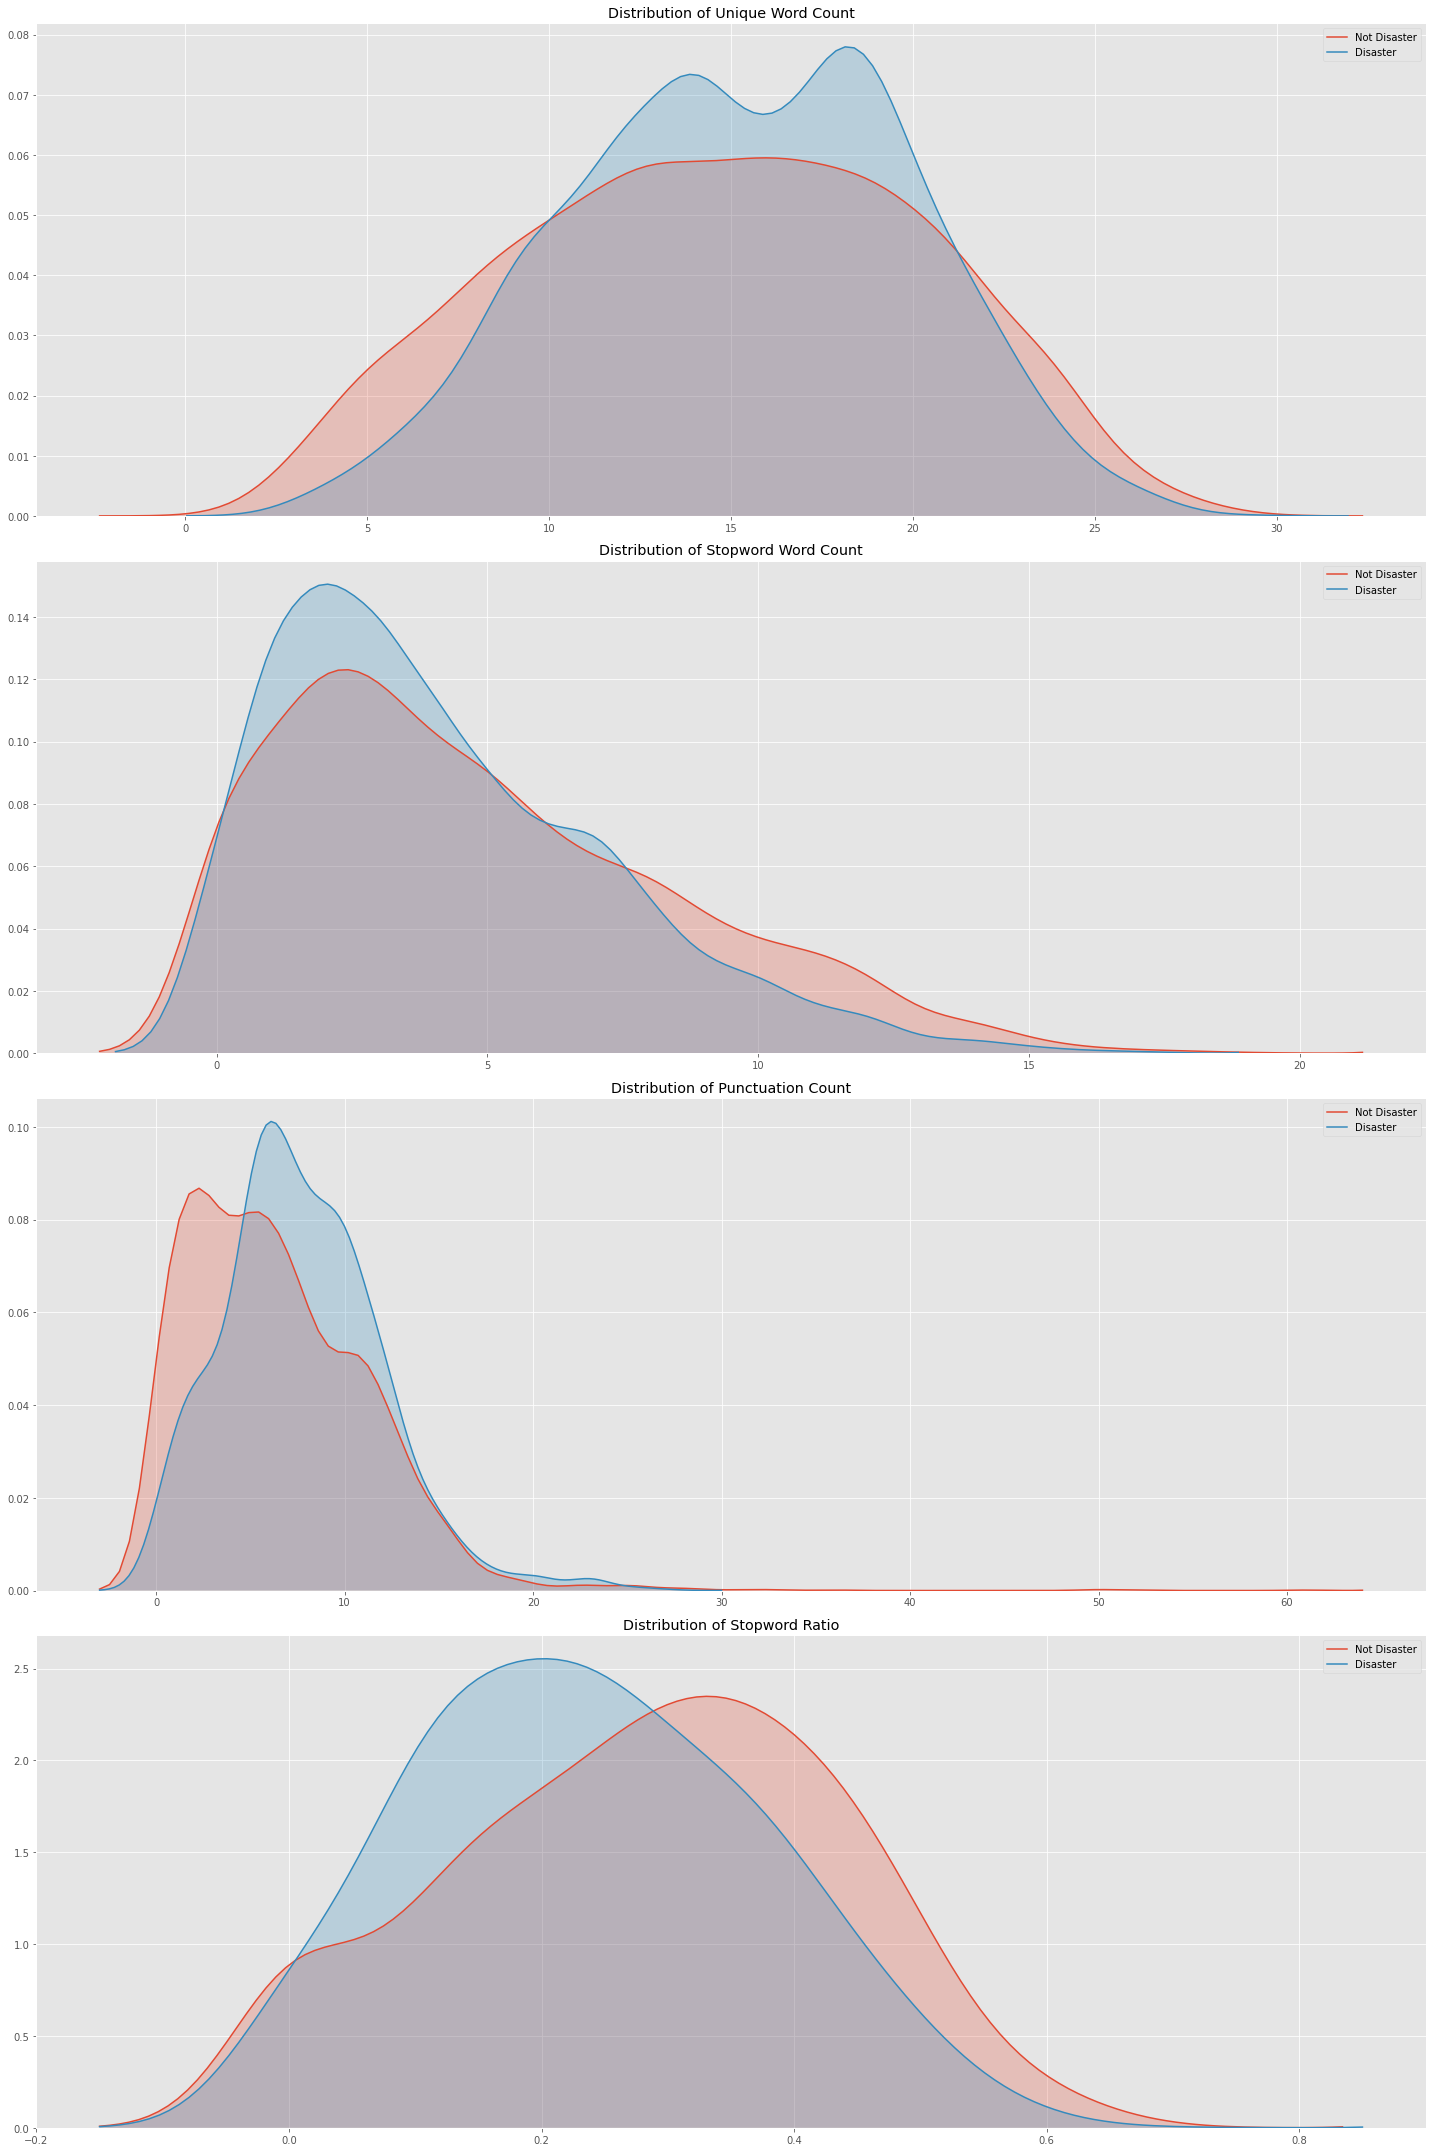

In [10]:
stopwords = stopwords.words('english')

#add unique word count
total['unique word count'] = total['text'].apply(lambda x: len(set(x.split())))

#add stopword count
total['stopword count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if i in stopwords]))

#add url count
#total['url count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if 'http' in i or 'https' in i]))

#add mention count
#total['mention count'] = total['text'].apply(lambda x: len([i for i in str(x) if i == '@']))

#add hashtag count
#total['hashtag count'] = total['text'].apply(lambda x: len([i for i in str(x) if i == '#']))

#add stopword ratio
total['stopword ratio'] = total['stopword count'] / total['word count']

#add punctuation count
total['punctuation count'] = total['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#split so we can use updated train set
train = total[:len(train)]

disaster = train['target'] == 1

#produce graphs to visualize newly added features
fig, axes = plt.subplots(4, figsize=(20, 30))

graph1 = sns.kdeplot(train.loc[~disaster]['unique word count'], shade = True, label = 'Not Disaster', ax=axes[0])
graph1 = sns.kdeplot(train.loc[disaster]['unique word count'], shade = True, label = 'Disaster', ax=axes[0])
graph1.set_title('Distribution of Unique Word Count')

graph2 = sns.kdeplot(train.loc[~disaster]['stopword count'], shade = True, label = 'Not Disaster', ax=axes[1])
graph2 = sns.kdeplot(train.loc[disaster]['stopword count'], shade = True, label = 'Disaster', ax=axes[1])
graph2.set_title('Distribution of Stopword Word Count')

graph3 = sns.kdeplot(train.loc[~disaster]['punctuation count'], shade = True, label = 'Not Disaster', ax=axes[2], bw = 1)
graph3 = sns.kdeplot(train.loc[disaster]['punctuation count'], shade = True, label = 'Disaster', ax=axes[2], bw = 1)
graph3.set_title('Distribution of Punctuation Count')

graph4 = sns.kdeplot(train.loc[~disaster]['stopword ratio'], shade = True, label = 'Not Disaster', ax=axes[3], bw = .05)
graph4 = sns.kdeplot(train.loc[disaster]['stopword ratio'], shade = True, label = 'Disaster', ax=axes[3], bw = .05)
graph4.set_title('Distribution of Stopword Ratio')

fig.tight_layout()
plt.show()

# II. Cleaning

**Now that we have explored our data, we need to prepare it for machine learning. In general, to process text we need to apply the following procedure:** 

> raw text corpus -> processing text -> tokenized text -> corpus vocabulary -> text representation 

**We can do most of the hard work with Keras's Tokenize object, which automatically converts all words to lowercase and filters out punctuation**  

**This tokenizer has many arguements that allow you to do most of the cleaning with one line of code, so we do not need to much processing ourselves. I have included some examples of how one would manually clean text for reference:**

In [11]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
StopWords = stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in StopWords])

#remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

#stem words
stemmer = SnowballStemmer('english')
def stem_words(x):
    return stemmer.stem(x)

#lemmatize words for verb
lemmatizer = WordNetLemmatizer()
def lemmatize_words_verb(x):
    return lemmatizer.lemmatize(x, 'v')

#lemmatize words for verb
lemmatizer = WordNetLemmatizer()
def lemmatize_words_noun(x):
    return lemmatizer.lemmatize(x, 'n')

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [12]:
#check strip_all_entities functionality
strip_all_entities('@shawn Titanic #tragedy could have been prevented Economic \
                   Times: Telegraph.co.ukTitanic tragedy could have been preve... http://bet.ly/tuN2wx')

'Titanic tragedy could have been prevented Economic Times Telegraph co ukTitanic tragedy could have been preve'

**Trick: we can even spell check words, although this is very computationally expensive:**

In [13]:
#install autocorrect
!pip install autocorrect
from autocorrect import Speller 

#create function to spell check strings
def spell_check(x):
    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

#showcase spellcheck 
mispelled = 'Pleaze spelcheck this sentince'
spell_check(mispelled)

'Please spellcheck this sentence'

In [14]:
#make lowercase
#total['text'] = total['text'].apply(lambda x: x.lower())

#remove url
#total['text'] = total['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))

#apply all of above functions
#total['text'] = total['text'].apply(remove_punctuation)
#total['text'] = total['text'].apply(remove_stopwords)
#total['text'] = total['text'].apply(remove_less_than)
#total['text'] = total['text'].apply(remove_non_alphabet)
#total['text'] = total['text'].apply(stem_words)
#total['text'] = total['text'].apply(lemmatize_words_noun)
#total['text'] = total['text'].apply(lemmatize_words_verb)
#total['text'] = total['text'].apply(spell_check)

**We should expand all the contractions in our vocabulary to ensure that we do not lose meaning when we tokenize everything. The below is taken from:**

> https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [15]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

expand_contractions("can't stop won't stop")

'cannot stop will not stop'

In [16]:
#apply to whole text column
total['text'] = total['text'].apply(expand_contractions)

**If you have the patience, it is also useful to correct as much text as you possibly can just to feed our model the best data possible. We can go through and separate hashtags/usernames, correct slang, and even spell check to ensure that our data is as clean as possible**

**Hint: try to come up with queries that allow you to view these hashtags, mispellings, etc. to expedite this process (or just steal the code below)**

In [17]:
 def clean(tweet):

    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)

    return tweet

total['text'] = total['text'].apply(clean)

# III. Base Model

## 1. Word Embeddings

**For reference: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html**

**One way to feed our model text data is to treat each word in our vocabulary as a separate feature and one hot encode them (Bag of Words encoding). This works and performs decently, but there is a major drawback to this approach**

### Mathematical intuition:

**We are interested in constructing a vector space to represent our words. Suppose our vocabulary is: 'cat', 'dog', 'plant', 'leaf', 'man', woman'. Then our vector space is,**

$$ cat = (1, 0, 0, 0, 0, 0) $$
$$ dog = (0, 1, 0, 0, 0, 0) $$
$$ plant = (0, 0, 1, 0, 0, 0) $$
$$ leaf = (0, 0, 0, 1, 0, 0) $$
$$ man = (0, 0, 0, 0, 1, 0) $$
$$ woman = (0, 0, 0, 0, 0, 1) $$

**But these vectors form an orthogonal basis, so when we take the dot product of them, we get 0:**

$$ cat \cdot dog = (1, 0, 0, 0, 0, 0) \cdot (0, 1, 0, 0, 0, 0) = 0$$

**This means that all of these vectors are as far as possible from each other in the vector space, i.e., they are not similar. But words like cat and dog are similar in meaning, so it would be great if our word encoddings could somehow capture this similarity**

**So, instead of following the Bag of Word approach, we will import the pre-trained words from GloVe and use them to construct our word embeddings. But what is GloVe?**  

> "GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space."

**For example, we can take the vector for King and subtract the vector for Man and the resulting vector is remarkably close to the vector for Queen. Using these word encodings as opposed to the Bag of Word encodings will substantially improve our classification accuracy**

In [18]:
#define our tweet vocab
tweets = [tweet for tweet in total['text']]

#split data to update changes
train = total[:len(train)]
test = total[len(train):]

**Now, some of the GloVe embeddings actually have tokens for punctuation, so for completeness, I will show you how to include punctuation in your embeddings if you think it will improve the accuracy of your model:**

In [19]:
from keras.preprocessing.text import Tokenizer

#find way to tokenize punctuation
to_exclude = '*+-/()%\n[\\]{|}^_`~\t'
to_tokenize = '!"#$&?:;<=>@'
tokenizer = Tokenizer(filters = to_exclude)
text = 'Why are you so f%#@ing angry all the time?!'
text = re.sub(r'(['+to_tokenize+'])', r' \1 ', text)
tokenizer.fit_on_texts([text])

#view new text
print(tokenizer.word_index)

{'why': 1, 'are': 2, 'you': 3, 'so': 4, 'f': 5, '#': 6, '@': 7, 'ing': 8, 'angry': 9, 'all': 10, 'the': 11, 'time': 12, '?': 13, '!': 14}


Using TensorFlow backend.


**That did the trick! We won't be using punctuation embedding for this notebook, but it is worth playing around to see if doing so improves your model's performance**

In [20]:
#broadcast to entire text column
#total['text'] = total['text'].apply(lambda x: re.sub(r'(['+to_tokenize+'])', r' \1 ', x))

**We can also include the `oov_token` parameter in the Keras Tokenizer object so that when the tokenizer finds words that our out of vocabulary in the test set, instead of skipping them, it includes them as a token of our choosing, we just need to ensure our token does not resemble any other words in our vocabulary. However, since we will ultimately embed our words as GloVe vectors, this step is useless. But if you were using your own embeddings, it could prove useful, so I will include it below:**

In [21]:
from keras.preprocessing.sequence import pad_sequences
from keras import Input

#define tokenizer options
tokenizer = Tokenizer()     
#tokenizer = Tokenizer(oov_token = '<OOV>')           #if you wanted to tokenized OOV words
#tokenizer = Tokenizer(filters = to_exclude)          #if you wanted to include punctuation
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

X_train = data[:len(train)]
y_train = labels
X_test = data[len(train):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 29279 unique tokens.
Shape of data tensor: (10876, 40)
Shape of label tensor: (7613,)


**Note: there are several variants of the GloVe vectors. Some are trained on different sources (Wikipedia vs. Twitter) and they all come in different dimensions. We will try both Wikipedia and Twitter based embeddings, typically using the higher dimensional representations, either 200D or 300D**

**The main difference between the Wikipedia and Twitter GloVe vectors is that there are only 400,000 words in the former's vocabulary whereas there are over a million words in the latter's. For more information:**

> https://nlp.stanford.edu/projects/glove/

**Note: After tinkering around, I concluded that the Wikipedia GloVe embeddings worked best for my model. That being said, I am sure one could leverage the Twitter corpus to create a model that outperforms mine**

In [22]:
#get GloVe vector embeddings
embeddings_index = {}
with open('glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in the GloVe library' % len(embeddings_index))

400000it [00:23, 16674.04it/s]

Found 400000 word vectors in the GloVe library


In [23]:
EMBEDDING_DIM = 200   #defined by size of GloVe word vector dimensions

In [24]:
#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

100%|██████████| 29279/29279 [00:00<00:00, 581705.57it/s]


In [25]:
print("Our embedded matrix is of dimension", embedding_matrix.shape)

Our embedded matrix is of dimension (29280, 200)


In [26]:
#import neural network basic
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  

#we do not want embedding layer to train since it has been pretrained

**Now, we could just feed our model our word embeddings, but we could also add the features we added during our initial exploration to improve performance**

**This 'meta input' contains information about the tweets that is no longer available to our model because of how we processed and cleaned the text, such as number of the URLs in a tweet.**  

**To include these features in our model, we pass our NLP data through our LSTM layer and then add the scaled meta input to it before the final layer:**

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#define and scale our added features
meta_input_train = StandardScaler().fit_transform(train.iloc[:, 2:])
meta_input_test = StandardScaler().fit_transform(test.iloc[:, 2:])

#meta_input_train = MinMaxScaler().fit_transform(train.iloc[:, 2:])
#meta_input_test = MinMaxScaler().fit_transform(test.iloc[:, 2:])

#meta_input_train = RobustScaler().fit_transform(train.iloc[:, 2:])
#meta_input_test = RobustScaler().fit_transform(test.iloc[:, 2:])

## 2. Simple LSTM Model

**We will now design a Long Short-Term Memory (LSTM) recurrent neural network to classify our tweets to see how it performs on the leaderboard**  

**For those who want to learn more about Reccurent Neural Networks (RNN), the following video from MIT is an excellent resource:**  

> https://www.youtube.com/watch?v=SEnXr6v2ifU

**We will add various levels of dropouts and a regularizer to our LSTM layer to control overfitting (as LSTM models are prone to do). For more information, see the below articles:**

> https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
> https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/  
> https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/

In [28]:
#function to create lstm model
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)        
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [29]:
#define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [30]:
#create our first model
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)
lstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 200)      5856000     nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 40, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200)          240800      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [31]:
#fit model
history1 = lstm.fit([X_train, meta_input_train], y_train, validation_split = .2,
                       epochs = 15, batch_size = 21, verbose = 1)

Train on 6090 samples, validate on 1523 samples
Epoch 1/15
6090/6090 [==============================] - 30s 5ms/step - loss: 0.5341 - accuracy: 0.7366 - val_loss: 0.4357 - val_accuracy: 0.7971
Epoch 2/15
6090/6090 [==============================] - 25s 4ms/step - loss: 0.4644 - accuracy: 0.7890 - val_loss: 0.4232 - val_accuracy: 0.8004
Epoch 3/15
6090/6090 [==============================] - 25s 4ms/step - loss: 0.4521 - accuracy: 0.7992 - val_loss: 0.4104 - val_accuracy: 0.8089
Epoch 4/15
6090/6090 [==============================] - 25s 4ms/step - loss: 0.4405 - accuracy: 0.8020 - val_loss: 0.4172 - val_accuracy: 0.8056
Epoch 5/15
6090/6090 [==============================] - 25s 4ms/step - loss: 0.4288 - accuracy: 0.8130 - val_loss: 0.4067 - val_accuracy: 0.8234
Epoch 6/15
6090/6090 [==============================] - 26s 4ms/step - loss: 0.4246 - accuracy: 0.8128 - val_loss: 0.4014 - val_accuracy: 0.8175
Epoch 7/15
6090/6090 [==============================] - 25s 4ms/step - loss: 0.429

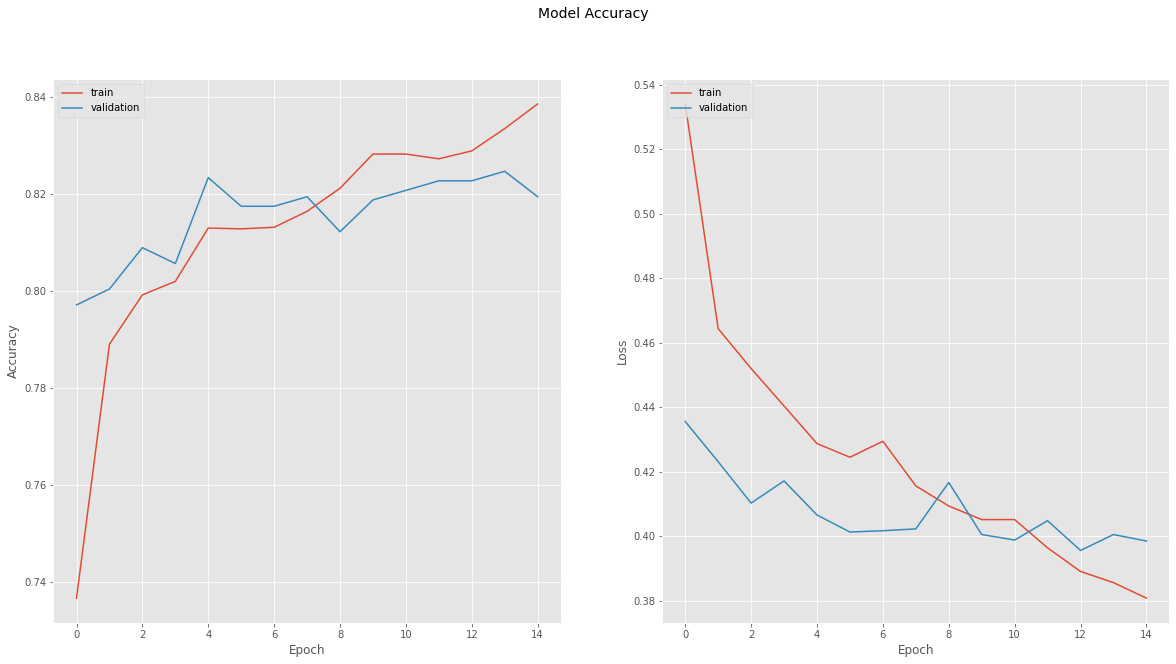

In [32]:
#view model 1 learning curves
plot_learning_curves(history1)

## 3. A Note on  Overfitting

**Dropout layers can help reduce overfitting, but there is no obvious way to add them and where to add them, so we will just have to experiment a bit**

**For the curious reader, the article below is very informative:**

> https://arxiv.org/pdf/1512.05287.pdf

**Hint: you can also implement a callback that automatically halts model training when your performance decreases. This can also serve as a layman's grid search for epochs, seeing as you will be able to see at which epoch your model is optimized. I have already determined the optimal epoch range by trial and error, but I would recommend including a call back during your first pass of model training. Below is an easy way to include it:**

In [33]:
#define early stopping callback
callback = EarlyStopping(monitor = 'val_loss', patience = 4)

#include it in your models training
#history = model.fit(X_train, y_train, validation_split = .2, epochs = 100, callbacks = [callback])

**You can monitor by different metrics, the most important being val_accuracy and val_loss. To prevent overfitting, I recommend selecting val_loss as your monitoring parameter. The patience arguement is just the number of epochs before stopping once the monitoring parameter stops improving**

**Note: if you use a smaller batch size (or a larger learning rate), the val_loss will be noisier (zig-zag more) so you need to set a larger patience arguement to ensure your model does not prematurely end it's training**

# IV. More Complex Model(s)

**In this section we will see if adding additional layers improves performance. We also changed the model's optimizer to LeakyRelu which allows the model to retain some information about the negative values that propogate through it. It is more computationally expensive and its performance is not consistent, so in practice it is not used much, but let's experiment with it here:**

## 1. Adding Hidden Layers

**We will now add a fully connected hidden layer after our LSTM layer. We will use ReLu activation for this layer, so it is best to use orthogonal initialization. See below links for more on LSTMs and optimal initializers:**

> https://arxiv.org/pdf/1702.00071.pdf
> https://smerity.com/articles/2016/orthogonal_init.html

In [34]:
#function to create lstm model
def create_lstm_2(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                      kernel_initializer = 'orthogonal'))(emb)
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(100, activation = activation, kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal'))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [35]:
#define new model
lstm_2 = create_lstm_2(spatial_dropout = .4, dropout = .4, recurrent_dropout = .4,
                       learning_rate = 3e-4, bidirectional = True)

lstm_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 200)      5856000     nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 40, 200)      0           embedding_1[1][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200)          240800      spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

In [36]:
history2 = lstm_2.fit([X_train, meta_input_train], y_train, validation_split = .2,
         epochs = 45, batch_size = 21, verbose = 1) #callbacks = [callback]

Train on 6090 samples, validate on 1523 samples
Epoch 1/45
6090/6090 [==============================] - 28s 5ms/step - loss: 0.6591 - accuracy: 0.6305 - val_loss: 0.5184 - val_accuracy: 0.7774
Epoch 2/45
6090/6090 [==============================] - 26s 4ms/step - loss: 0.5761 - accuracy: 0.7271 - val_loss: 0.4660 - val_accuracy: 0.7951
Epoch 3/45
6090/6090 [==============================] - 27s 4ms/step - loss: 0.5452 - accuracy: 0.7453 - val_loss: 0.4583 - val_accuracy: 0.8024
Epoch 4/45
6090/6090 [==============================] - 26s 4ms/step - loss: 0.5221 - accuracy: 0.7677 - val_loss: 0.4472 - val_accuracy: 0.7945
Epoch 5/45
6090/6090 [==============================] - 26s 4ms/step - loss: 0.5142 - accuracy: 0.7693 - val_loss: 0.4399 - val_accuracy: 0.8017
Epoch 6/45
6090/6090 [==============================] - 26s 4ms/step - loss: 0.5162 - accuracy: 0.7678 - val_loss: 0.4368 - val_accuracy: 0.8096
Epoch 7/45
6090/6090 [==============================] - 26s 4ms/step - loss: 0.504

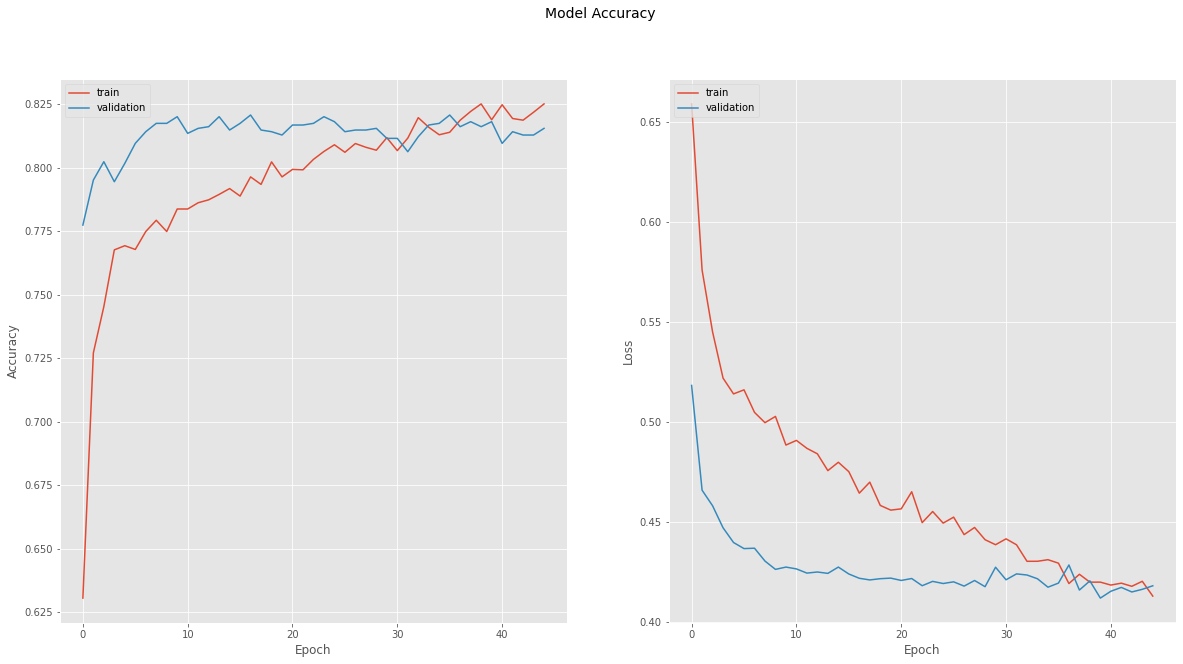

In [37]:
plot_learning_curves(history2)

## 2. Dual LSTM Layers

**Now we will take the output of one LSTM layer and feed it directly into another LSTM layer. This is easy to do, the only change being we need to set `return_sequences` = True on the first layer:**

In [38]:
#function to create dual lstm model
def create_dual_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add dual LSTM layers
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal', return_sequences = True)))(emb)
        nlp_out = SpatialDropout1D(dropout)(nlp_out)
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal', return_sequences = True))(emb)
        nlp_out = SpatialDropout1D(dropout)(nlp_out)
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)
     
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    #x = Dropout(dropout)(x)
    #x = (Dense(100, activation = activation, kernel_regularizer = regularizers.l2(1e-4),
              #kernel_initializer = 'he_normal'))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [39]:
#define new model
dual_lstm = create_dual_lstm(spatial_dropout = .4, dropout = .4, recurrent_dropout = .4,
                       learning_rate = 3e-4, bidirectional = True)

In [40]:
history3 = dual_lstm.fit([X_train, meta_input_train], y_train, validation_split = .2,
         epochs = 50, batch_size = 21, verbose = 1) #callbacks = [callback]

Train on 6090 samples, validate on 1523 samples
Epoch 1/50
6090/6090 [==============================] - 27s 4ms/step - loss: 0.6238 - accuracy: 0.6455 - val_loss: 0.4715 - val_accuracy: 0.7846
Epoch 2/50
6090/6090 [==============================] - 26s 4ms/step - loss: 0.5303 - accuracy: 0.7493 - val_loss: 0.4583 - val_accuracy: 0.7892
Epoch 3/50
6090/6090 [==============================] - 26s 4ms/step - loss: 0.5127 - accuracy: 0.7542 - val_loss: 0.4423 - val_accuracy: 0.7971
Epoch 4/50
6090/6090 [==============================] - 26s 4ms/step - loss: 0.4981 - accuracy: 0.7668 - val_loss: 0.4347 - val_accuracy: 0.7978
Epoch 5/50
6090/6090 [==============================] - 26s 4ms/step - loss: 0.4816 - accuracy: 0.7814 - val_loss: 0.4253 - val_accuracy: 0.8116
Epoch 6/50
6090/6090 [==============================] - 26s 4ms/step - loss: 0.4822 - accuracy: 0.7800 - val_loss: 0.4273 - val_accuracy: 0.8116
Epoch 7/50
6090/6090 [==============================] - 26s 4ms/step - loss: 0.477

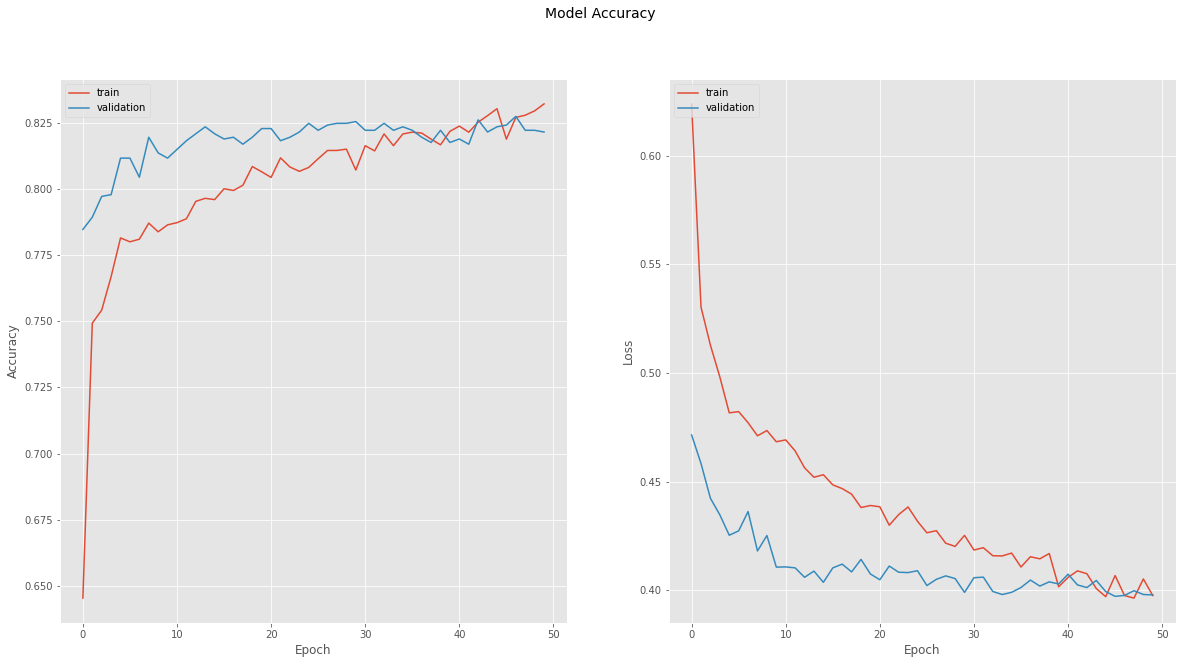

In [41]:
plot_learning_curves(history3)